I had a kid at the start of the year.

*Hold for applause*

Well, not me personally, but my wife did.

I only tell you this in order to tell you that I took a picture of my wife every week that she was pregnant. 

We thought maybe it'd be interesting to look back at these pictures one day. She wore the same outfit and faced the same direction for each picture, although the background occasionally changed. In an attempt to be less neurotic about things in my life, I deliberately did not use a tripod or try to get the picture from the exact same angle and distance. 

In the end, a child was born, and I immediately forgot about said pictures because who cares about such things at 4 in the morning?

Well, some time has passed, and the kid's sleeping through the night.

*Hold for applause*

I now have some free time and thought it'd be cool to make an animation of those pregnancy pictures. Given my photographic imperfectionism, I needed to crop, rotate, and align the images for the animation. Of course, I did not want to do this manually. How long could it take to [automate](https://xkcd.com/1319/)?

...

Obviously, it took much longer to automate than to do manually, but now I get to talk about how I made this video using Differentiable, Semantic Image Registration with Kornia.

<video style="display:block; width:100%; height:auto;" autoplay="" muted="" loop="loop">
    <source src="videos/alignimation/body_alignimation_scaled.mp4" type="video/mp4">
</video>

*Note: As with most of my blog posts, I wrote this one in a jupyter notebook. I'm going to reference a package called [alignimation](https://github.com/EthanRosenthal/alignimation) in the code. This is just a small library I made to house my code and make this blog post more readable.*

## Photo Ops

To understand the problem at hand, let's look at two different images that I want to align:

In [ ]:
%config InlineBackend.figure_format = 'retina'

from pathlib import Path

import alignimation
import kornia as K
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

In [2]:
imgs = alignimation.io.load_images(Path("body_pics"))

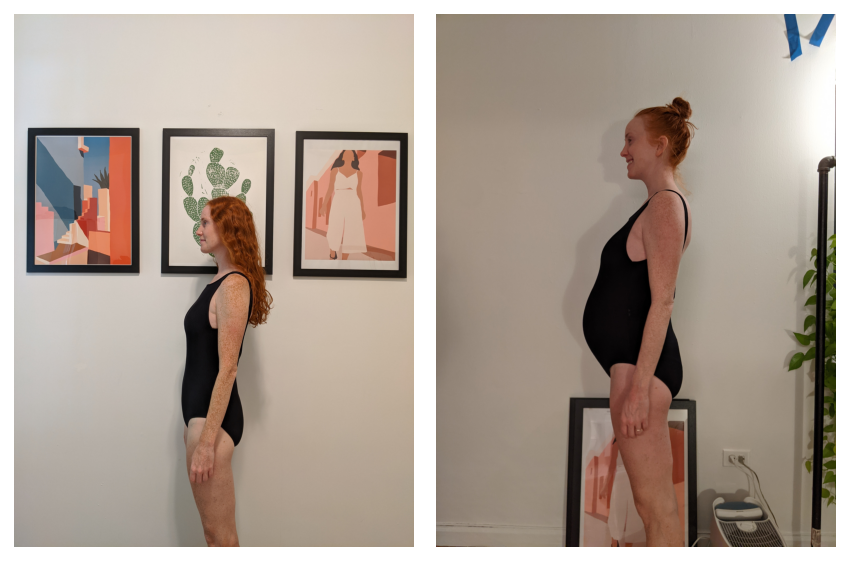

In [3]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(K.tensor_to_image(imgs[0]))
axs[1].imshow(K.tensor_to_image(imgs[22]))
axs[0].axis("off")
axs[1].axis("off")
fig.tight_layout()
None

The goal here is to modify either picture in such a way that the bodies are [registered](https://en.wikipedia.org/wiki/Image_registration) with each other. You could imagine multiple different *operations* that one could perform on the image to make this happen: you can shift the image in a direction, you can zoom in or out, and you can rotate the image. (You could also do other plausible things like shear the image, but we'll ignore those operations).

An image is a 3D matrix (or tensor in modern terms). There's a height and width dimension for each pixel, and then 3 channel dimensions (red, green, and blue).

In [4]:
print(type(imgs[0]))
print(imgs[0].shape)

<class 'torch.Tensor'>
torch.Size([1, 3, 4032, 3024])


In the world of linear algebra, the operations that we would like to perform are well known matrix transformations: translation, scaling, and rotation. These can be done purely in `numpy` or with a host of other libraries.

So great, we can figure out how to transform the images, but how much do we transform each image?

## Differentation through Differentiation

A couple years ago, I gave a [talk](https://youtu.be/OoGaFn3aaMU) at SciPy about all the non deep learning reasons why deep learning frameworks are exciting. One of those reasons is automatic differentiation: as long as you can express your "model" using the deep learning framework, then you can optimize all sorts of objective functions without having to write any calculus.

Getting back to our automated image registration problem, if I can

1. Define my image transformations using a deep learning framework
2. Come up with an objective function that describes how registered two images are

then I can optimize that objective function in order to find the optimal image transformation parameters.

Towards the end of that talk I gave, I mention how it would be really great if we rebuilt all sorts of special purpose libraries on top of deep learning frameworks so that we get the benefit of automatic differentiation, along with all sorts of other things like GPU speedups.

[kornia](https://kornia.github.io/) is exactly one of those libraries that I was hoping would be built. `kornia` provides many of the features of "classical" computer vision libraries like [OpenCV](https://opencv.org/) and the MATLAB [Image Processing Toolbox](https://www.mathworks.com/products/image.html), but it's built on top of [PyTorch](https://pytorch.org/). Crucially, all of the image transformations in `kornia` are differentiable PyTorch modules.

## What's the Objective?

A simple objective function to optimize would be the absolute (L1) difference between every pixel of two different images. When the images are aligned, the pixels would presumably have similar values. Thus, we could minimize this objective function. 

While I was working on this project, a new version of `kornia` was released which had functionality for exactly this: the [ImageRegistrator](https://kornia.readthedocs.io/en/latest/geometry.transform.html#kornia.geometry.transform.image_registrator.ImageRegistrator) module _learns_ a model of image transformations in order to minimize the L1 loss between two images.

While this might work for my use case, I was worried that the background of my images would interfere with optimizing the alignment of my wife. Thankfully, since we're already using PyTorch, we can use [torchvision](https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection) to easily pick out the body in an image.

In [ ]:
from torchvision.models.detection import maskrcnn_resnet50_fpn

segmentation_model = maskrcnn_resnet50_fpn(
    pretrained=True, progress=False
)
segmentation_model = segmentation_model.eval()
person_index = (
    alignimation.constants.COCO_INSTANCE_CATEGORY_NAMES.index("person")
)
masks = alignimation.base.get_segmentation_masks(
    torch.cat([imgs[0], imgs[22]]), 
    segmentation_model, 
    "cpu", 
    person_index
)

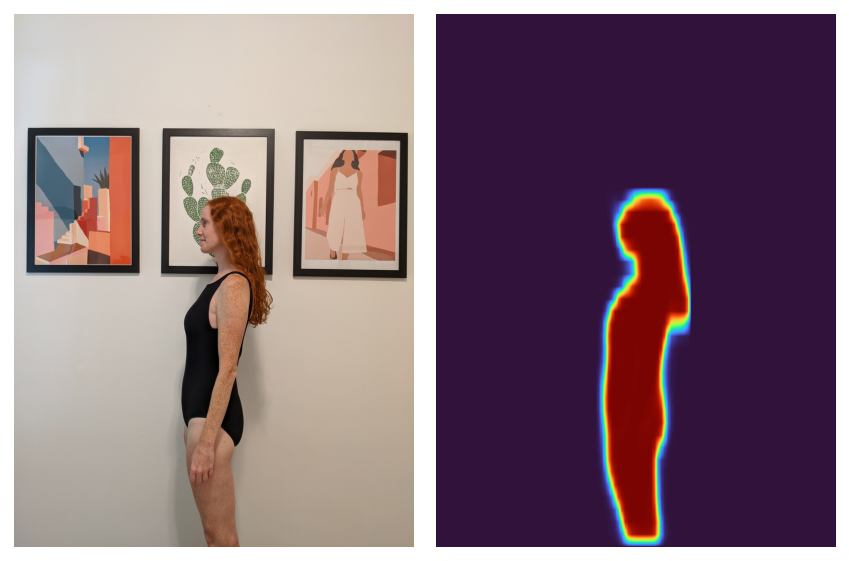

In [6]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(K.tensor_to_image(imgs[0]))
axs[1].imshow(
    K.tensor_to_image(masks[0]), cmap=plt.get_cmap("turbo")
)
axs[0].axis("off")
axs[1].axis("off")
fig.tight_layout()
None

Now that we can pick out the body, the recipe is:

1. Create the "segmentation mask" corresponding to the body in the image.
1. Fit an `ImageRegistrator` to align the segmentation masks.
1. Use the trained `ImageRegistrator` to register the actual image.

Remember when I said I was trying to be less neurotic? Unfortunately, that all went out the window when I started writing code. I worried that my wife's changing body would affect the alignment of the segmentation mask as the center of mass gets pulled to the le-- I mean, as the baby grows. Also, my wife's hair is sometimes up and sometimes down, and the segmentation mask includes the hair.

How to align just the body and neither the baby nor the hair? Again, `torchvision` to the rescue. Using a [keypoint](https://pytorch.org/vision/stable/models.html#keypoint-r-cnn) model, we can pick out the left ear, shoulder, and hip.

In [7]:
from torchvision.models.detection import keypointrcnn_resnet50_fpn

In [ ]:
keypoint_model = keypointrcnn_resnet50_fpn(
    pretrained=True, progress=False
)
keypoint_model = keypoint_model.eval()
keypoint_names = ["left_ear", "left_shoulder", "left_hip"]
keypoint_indices = [
    alignimation.constants.BODY_KEYPOINT_NAMES.index(k) 
    for k in keypoint_names
]
keypoints = alignimation.base.get_keypoints(
    keypoint_model, 
    torch.cat([imgs[0], imgs[22]]), 
    "cpu", 
    1, 
    keypoint_indices
)

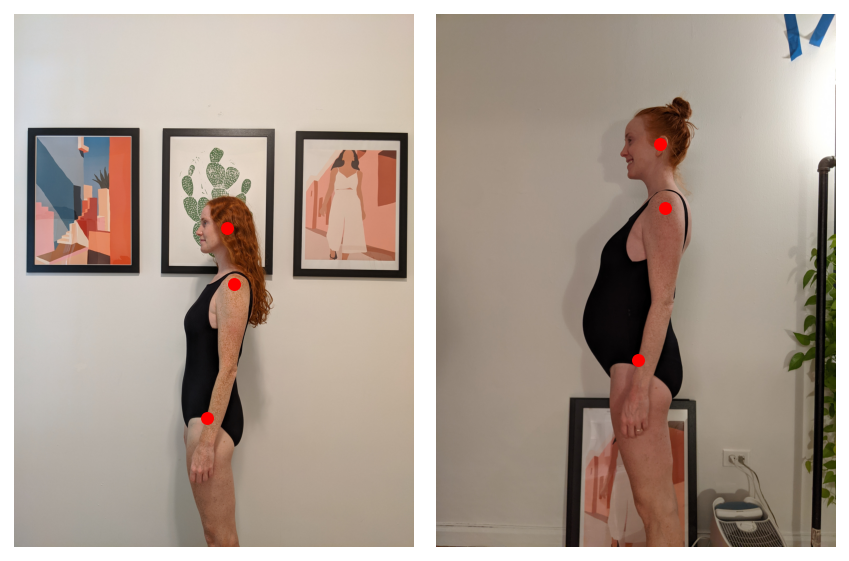

In [9]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(K.tensor_to_image(imgs[0]))
axs[0].scatter(
    x=keypoints[0, :, 0],
    y=keypoints[0, :, 1],
    s=30,
    marker="o",
    color="red",
)
axs[1].imshow(K.tensor_to_image(imgs[22]))
axs[1].scatter(
    x=keypoints[1, :, 0],
    y=keypoints[1, :, 1],
    s=30,
    marker="o",
    color="red",
)
axs[0].axis("off")
axs[1].axis("off")
fig.tight_layout()
None

It may be hard to optimize the registration of 3 individual points, so let's interpolate between the segmentation mask and the keypoints: I'm going to create 2D Gaussians around each keypoint and then multiply those by the segmentation mask. This should all make for a nice, smooth optimization.

In [10]:
gaussians = alignimation.base.make_keypoint_gaussians(
    keypoints, imgs[0].shape[-2:]
)
gaussian_masks = masks * gaussians

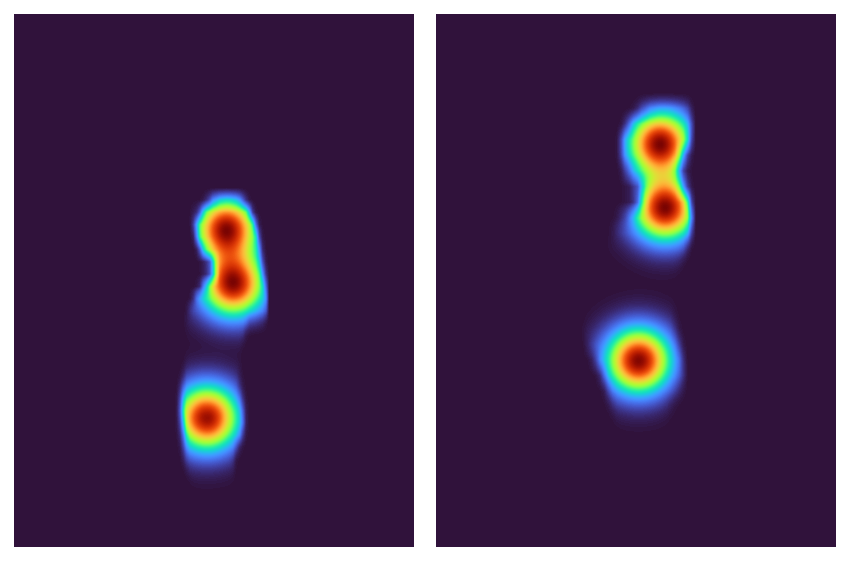

In [11]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(
    K.tensor_to_image(gaussian_masks[0].sum(dim=0, keepdim=True)),
    cmap=plt.get_cmap("turbo"),
)
axs[1].imshow(
    K.tensor_to_image(gaussian_masks[1].sum(dim=0, keepdim=True)),
    cmap=plt.get_cmap("turbo"),
)
axs[0].axis("off")
axs[1].axis("off")
fig.tight_layout()
None

All that's left now is to finally register the two masks with each other. In keeping with our smooth optimization directive, we'll use an L2 loss.

In [12]:
registrator = K.geometry.ImageRegistrator(
    "similarity", tolerance=1e-8, loss_fn=F.mse_loss
)

In [13]:
_ = registrator.register(gaussian_masks[[1]], gaussian_masks[[0]])

After fitting the model to register the two masks, it can be used to register the two images.

In [14]:
with torch.inference_mode():
    aligned_mask = registrator.warp_src_into_dst(gaussian_masks[[1]])
    aligned_img = registrator.warp_src_into_dst(imgs[22])

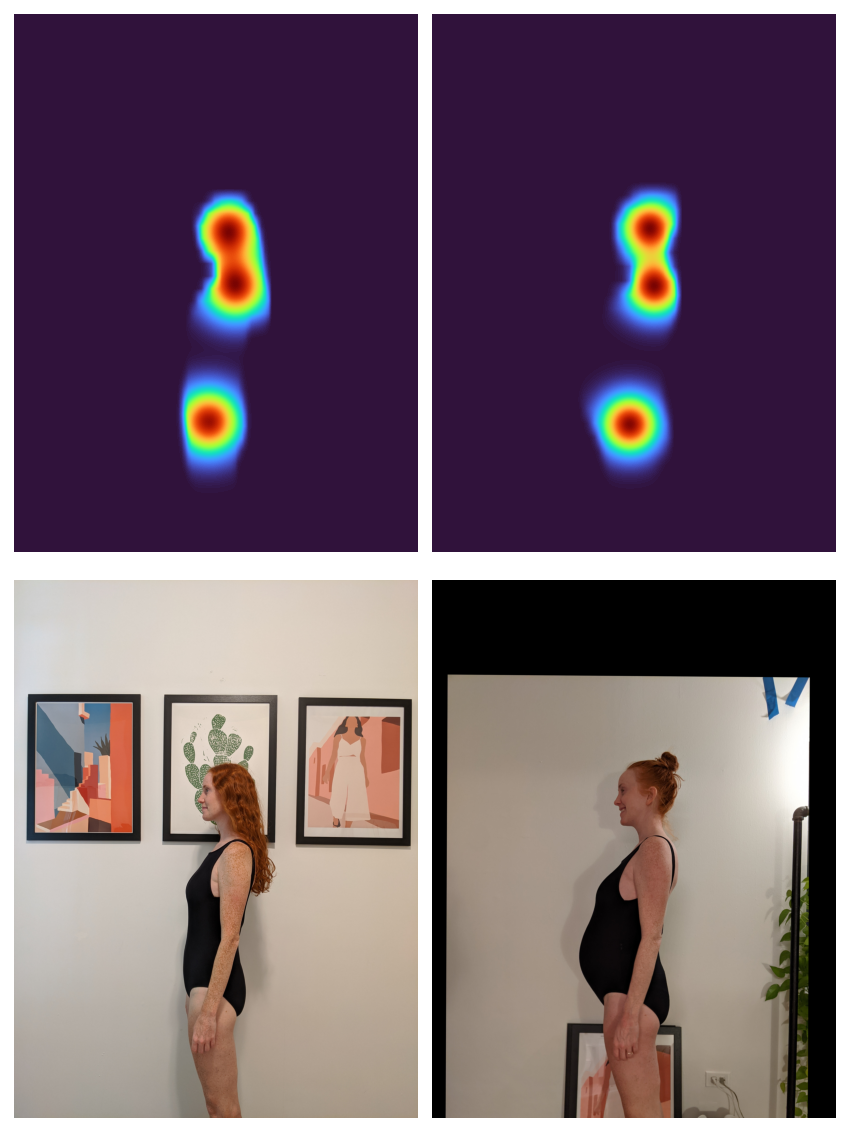

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(6, 8))
axs = axs.flatten()
axs[0].imshow(
    K.tensor_to_image(gaussian_masks[0].sum(dim=0, keepdim=True)),
    cmap=plt.get_cmap("turbo"),
)
axs[1].imshow(
    K.tensor_to_image(aligned_mask[0].sum(dim=0, keepdim=True)),
    cmap=plt.get_cmap("turbo"),
)
axs[2].imshow(K.tensor_to_image(imgs[0]))
axs[3].imshow(K.tensor_to_image(aligned_img))
for ax in axs:
    ax.axis("off")
fig.tight_layout()
None

Huzzah! In order to make the "alignimation" at the top of this post, I followed the above process for all of my photos.

As a bonus, since I already had the body segmentation mask, I can hackily remove the background:

<video style="display:block; width:100%; height:auto;" autoplay="" muted="" loop="loop">
    <source src="videos/alignimation/body_alignimation_no_background.mp4" type="video/mp4">
</video>

## Fleeting Youth

As I was working on this, I realized that this code could be reused for any scenario where one wants to align a bunch of keypoints or segmentation masks. Albeit way creepy and surveillance-y, one could pick out facial keypoints and align a bunch of pictures of the same person.

Speaking of surveillance, I store all of my photos in Google Photos. In addition to storing pictures that I take with my phone, I've also uploaded a bunch of old digital pictures going back to sometime circa 2000. 

An alarming but convenient feature of Google Photos is that it will automatically start detecting different peoples' faces in your pictures and create albums containing only pictures of this person. The algorithm is surprisingly good and has been able to follow me through time and hair.

I downloaded > 1,000 pictures of myself going back 20 years and decided to make an animation of myself aging throughout the years. As usual, this slight variation on the aforementioned alignment task ended up being more-than-slightly complicated.


## Facial Awareness

The process for aligning my face is similar to the previous process:

1. Pick out my face in the images
1. Pick out facial keypoints.
1. Make 2D Gaussian masks around the facial keypoints.
1. Register the Gaussian masks and then transform the original image.

However, because these were images "in the wild" rather than images that I explicitly took in the same way, the first two steps were more involved.

Noteably missing from `torchvision` are any pretrained models for detecting faces or facial keypoint (I assume this is on purpose?). Instead, I used [facenet-pytorch](https://github.com/timesler/facenet-pytorch) to detect all faces in each image. Each detected face gets a bounding box and a set of facial "landmarks" (aka keypoints) corresponding to both eyes, the nose, and both corners of the lips.

<img style='width: 320px; padding: 10px'  src='images/alignimation/face_landmarks.jpg' />

With this tool in my toolbox, my process then looked like:

1. Detect all faces in all images.
1. Pick out my face in each image.
1. Pick out my facial keypoints.
1. Throw out images where I'm not facing forward.

I picked out my face in the image by first constructing embeddings for all detected faces in all images using the last layer of a pretrained model. I then contructed an embedding to represent myself by taking the average of all embeddings. Since I'm in every image, I ought to "dominate" the average. I then look through each image and find the face embedding that's closest to mine and assume that that's me.

I determine whether or not I'm facing forward by measuring the distance between my nose and either eye. If one eye is a lot closer to my nose than the other eye, then I assume I'm looking sideways and throw out the image. I also do the same check for the distance between my lip corners and nose. This heuristic fails for scenarios where I'm looking down or up.

## All Together Now

After following the above process to extract my face's keypoints from every image, I can then feed the images and keypoints into my original semantic image registration procedure and get a final "alignimation" of two decades of Ethans.

<video style="display:block; width:100%; height:auto;" autoplay="" muted="" loop="loop">
    <source src="videos/alignimation/ethan_alignimation_scaled.mp4" type="video/mp4">
</video>

